In [1]:
import h5py
import matplotlib.pyplot as plt
import mpl_lego as mplego
import neuropacks as packs
import numpy as np
import os
import pickle

from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from mpl_lego.ellipse import plot_cov_ellipse
from noise_correlations import analysis, utils 
from scipy.stats import spearmanr, ttest_1samp
from settings import colors, titles, ax_label_size, tick_label_size, letter_size, legend_size

In [2]:
ccycle = mplego.colors.get_default_ccycle()

In [3]:
exp = 10
base_path = f"/storage/noise_correlations/exp{exp}"

In [4]:
ret2_path = os.path.join(base_path, f'exp{exp}_ret2_20_1000_1000.h5')
pvc11_1_path = os.path.join(base_path, f'exp{exp}_1_pvc11_20_1000_1000.h5')
ecog_path = os.path.join(base_path, f'exp{exp}_ecog_20_3000_1000.h5')

In [5]:
ret2 = h5py.File(ret2_path, 'r')
pvc11_1 = h5py.File(pvc11_1_path, 'r')
ecog = h5py.File(ecog_path, 'r')
results = [ret2, pvc11_1, ecog]

In [6]:
n_max_units = pvc11_1['units'].shape[2]
dims = 3 + np.arange(n_max_units - 2)

In [7]:
with open(os.path.join(base_path, f'exp{exp}_ffs.pkl'), 'rb') as f:
    opt_r_ffs, opt_fa_ffs, obs_ffs = pickle.load(f)

In [8]:
# Calculate correlations between max CDFs and percentiles
fa_corrs = np.zeros((len(results), dims.size))

for result_idx, result in enumerate(results):
    for dim_idx, dim in enumerate(dims):
        fa_corrs[result_idx, dim_idx] = spearmanr(
            result['p_fa_lfi'][dim_idx],
            np.log(opt_fa_ffs[result_idx][dim_idx] / obs_ffs[result_idx][dim_idx]),
        ).correlation

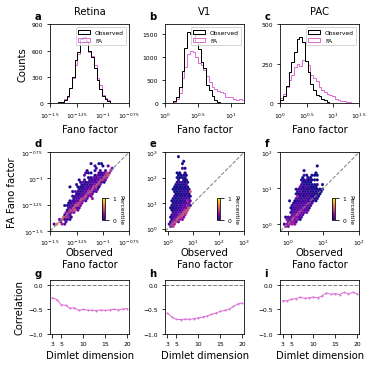

In [22]:
"""
Figure Settings
"""
figsize = (5, 5)

# Histogram settings
hist_lw = 1

# Layout settings
cb_spacing = 0.03
cb_width = 0.03

# Hexbin settings
gridsize = 30
hex_lw = .2

# Font sizes
title_pad = 10

model_labels = ['Observed', 'FA']
label_dict = {'observed': model_labels[0], 'fa': model_labels[1]}
bins = [
    np.linspace(-1.5, -0.75, 30),
    np.linspace(0, 1.2, 30),
    np.linspace(0, 1.5, 30)
]

"""
Figure 6
"""
fig = plt.figure(figsize=figsize)
le = .12
re = .021
te = .06
be = .08
rh = .15
hg = .1
w = (1. - le - re - 2.*hg) / 3.
h = w * figsize[0] / figsize[1]
vg = (1. - te - be - 2*h - rh) / 2.

axes = np.empty((3, 3), dtype=object)
caxes = np.empty(3, dtype=object)
axes[0] = [fig.add_axes([le + ii*(w + hg), be + rh + 2.*vg + h, w, h]) for ii in range(3)]
axes[1] = [fig.add_axes([le + ii*(w + hg), be + rh + 1.*vg, w, h]) for ii in range(3)]
axes[2] = [fig.add_axes([le + ii*(w + hg), be, w, rh]) for ii in range(3)]
caxes[:] = [fig.add_axes([le + ii*(w + hg) + .65*w, be + rh + vg+.03, .01, h/3.5]) for ii in range(3)]

dim_idx = 0
norms = [
    Normalize(vmin=0, vmax=1),
    Normalize(vmin=0, vmax=1),
    Normalize(vmin=0, vmax=1.0)
]
extents = [
    (-1.5, -0.75, -1.5, -0.75),
    (-.1, 3, -.1, 3),
    (-0.2, 2, -0.2, 2)
]


for idx, (result, norm, extent) in enumerate(zip(results, norms, extents)):
    # Calculate relevant quantities
    log_obs_ffs = np.log10(obs_ffs[idx][dim_idx])
    log_opt_fa_ffs = np.log10(opt_fa_ffs[idx][dim_idx])

    axes[0, idx].hist(
        [log_obs_ffs, log_opt_fa_ffs],
        histtype='step',
        color=[colors['observed'], colors['fa']],
        lw=hist_lw,
        bins=bins[idx])
    for key, label in label_dict.items():
        axes[0, idx].hist([], color=colors[key], label=label, histtype='step', lw=hist_lw)
    axes[0, idx].legend(
        loc='best',
        prop={'size': legend_size})
    axes[0, idx].set_xlabel(r'Fano factor', fontsize=ax_label_size)
    
    # Hexbin comparing FFs to FA null model
    percentiles = result['p_fa_lfi'][dim_idx]
    axes[1, idx].hexbin(
        log_obs_ffs,
        log_opt_fa_ffs,
        C=percentiles,
        gridsize=gridsize,
        cmap='plasma',
        extent=extent,
        norm=norm,
        linewidths=hex_lw)
    # Tighten hexbin plot
    mplego.scatter.tighten_scatter_plot(
        axes[1, idx],
        lim=extent[:2],
        color='gray',
        lw=1,
        linestyle='--')
    # Colorbar for hexbin
    cax = caxes[idx]
    fig.colorbar(ScalarMappable(norm=norm, cmap='plasma'), cax=cax)
    cax.set_ylabel(
        r'Percentile',
        fontsize=tick_label_size,
        rotation=270,
        labelpad=7)
    cax.tick_params(labelsize=tick_label_size)
    axes[1, idx].set_xlabel('Observed\nFano factor', fontsize=ax_label_size, labelpad=0)

    # Fourth Row    
    axes[2, idx].plot(
        dims,
        fa_corrs[idx],
        color=colors['fa'],
        marker='o',
        lw=1,
        markersize=1,
        zorder=1000)
    axes[2, idx].axhline(0, color='gray', linestyle='--', lw=1)


# Top row settings
axes[0, 0].set_xlim([-1.5, -0.75])
axes[0, 0].set_xticks([-1.5, -1.25, -1, -0.75])
axes[0, 0].set_xticklabels([r'$10^{-1.5}$', r'$10^{-1.25}$', r'$10^{-1}$', r'$10^{-0.75}$'])
axes[0, 0].set_ylim([0, 900])
axes[0, 0].set_yticks([0, 300, 600, 900])

axes[0, 1].set_xlim([0, 1.2])
axes[0, 1].set_xticks([0, 0.5, 1.])
axes[0, 1].set_xticklabels([r'$10^0$', r'$10^{0.5}$', r'$10^1$'])
axes[0, 1].set_ylim([0, 1700])
axes[0, 1].set_yticks([0, 500, 1000, 1500])

axes[0, 2].set_xlim([0, 1.5])
axes[0, 2].set_xticks([0, 0.5, 1., 1.5])
axes[0, 2].set_xticklabels([r'$10^0$', r'$10^{0.5}$', r'$10^1$', r'$10^{1.5}$'])
axes[0, 2].set_ylim([0, 500])
axes[0, 2].set_yticks([0, 250, 500])
axes[0, 0].set_ylabel(r'Counts', fontsize=ax_label_size)

# Middle row settings
axes[1, 0].set_xticks([-1.5, -1.25, -1, -0.75])
axes[1, 0].set_xticklabels([r'$10^{-1.5}$', r'$10^{-1.25}$', r'$10^{-1}$', r'$10^{-0.75}$'])
axes[1, 0].set_yticks(axes[1, 0].get_xticks())
axes[1, 0].set_yticklabels(axes[1, 0].get_xticklabels())

axes[1, 1].set_xticks([0, 1, 2, 3])
axes[1, 1].set_xticklabels([r'$10^0$', r'$10^1$', r'$10^2$', r'$10^3$'])
axes[1, 1].set_yticks(axes[1, 1].get_xticks())
axes[1, 1].set_yticklabels(axes[1, 1].get_xticklabels())

axes[1, 2].set_xticks([0, 1, 2])
axes[1, 2].set_xticklabels([r'$10^0$', r'$10^1$', r'$10^2$'])
axes[1, 2].set_yticks(axes[1, 2].get_xticks())
axes[1, 2].set_yticklabels(axes[1, 2].get_xticklabels())
axes[1, 0].set_ylabel(r'FA Fano factor', fontsize=ax_label_size)

# Bottom row settings
for ax in axes[-1]:
    ax.set_xlim([2.5, max(dims) + 0.5])
    ax.set_ylim([-1, 0.1])
    ax.set_xticks([3, 5, 10, 15, 20])
    ax.set_yticks([-1, -0.5, 0])
    ax.set_xlabel(r'Dimlet dimension', fontsize=ax_label_size)
axes[-1, 0].set_ylabel(r'Correlation', fontsize=ax_label_size)
#caxes[2].set_yticks([0, .5])
#caxes[2].set_yticklabels([0, .5])

# Apply titles
axes[0, 0].set_title(r'Retina', fontsize=ax_label_size, pad=title_pad)
axes[0, 1].set_title(r'V1', fontsize=ax_label_size, pad=title_pad)
axes[0, 2].set_title(r'PAC', fontsize=ax_label_size, pad=title_pad)

# Apply subplot labels
lets = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n']
c = 0
for ii in range(3):
    for jj in range(3):
        ax = axes[ii, jj]
        ax.text(-.2, 1.07, lets[c], size=letter_size, fontweight='bold',
                transform=ax.transAxes)
        c += 1
for ax in axes.ravel():
    ax.tick_params(labelsize=tick_label_size)
for ax in caxes:
    ax.tick_params(labelsize=tick_label_size)

plt.savefig('figure5.pdf', dpi=300)
plt.savefig('figure5.jpg', dpi=300)
plt.show()